In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix
from sklearn.preprocessing import normalize
from datetime import datetime
from geopy.distance import geodesic

In [11]:
path = '/content/drive/My Drive/16-791 Applied Data Science Project/'
incident_df = pd.read_csv('/content/drive/My Drive/16-791 Applied Data Science Project/Filtered_Incident_Report.csv')
incident_df = incident_df[incident_df['Latitude'].notna()]
crime_loc = list(zip(incident_df['Latitude'], incident_df['Longitude']))

In [ ]:
n = len(crime_loc)
dist = np.full(shape=(n, n), fill_value=float('inf'))
total = n*(n+1)//2
complete = 0
start_time = datetime.now()
percent_done = 0
thresh = 1    # 1 km radius
for i in range(n):
  for j in range(i+1, n):
    x, y = crime_loc[i], crime_loc[j]
    if abs(x[0]-y[0])>0.01 or abs(x[1]-y[1])>0.012:
      continue
    d = geodesic(crime_loc[i], crime_loc[j]).km
    if d<=thresh:
      dist[i, j] = dist[j, i] = d
  complete +=(n-i)
  percent = complete*100/total
  if percent>percent_done:
    time_diff = (datetime.now() - start_time).seconds
    print('{:.2f}% completed, {:02d}:{:02d}'.format(percent, time_diff//60, time_diff%60))
    percent_done+=1

(array([1., 0., 0., ..., 0., 0., 3.]),
 array([0.00000000e+00, 2.82608696e-01, 5.65217391e-01, ...,
        6.49434783e+02, 6.49717391e+02, 6.50000000e+02]),
 <a list of 2300 Patch objects>)

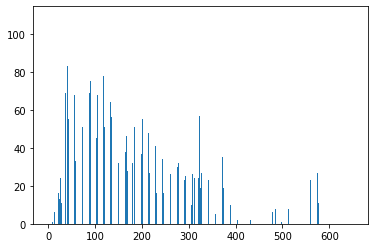

In [ ]:
# distribution of no. of crime spots within 1 km
import matplotlib.pyplot as plt
nearby_spot_count = np.count_nonzero(dist, axis=1)
plt.hist(nearby_spot_count, bins=2300)

In [ ]:
# Affinity Propagation and DBSCAN do not converge on large dataset
'''
from sklearn.cluster import AffinityPropagation
from sklearn.cluster import DBSCAN

aff_prop = AffinityPropagation(max_iter=100, convergence_iter=2, verbose=True, affinity='precomputed')
aff_prop.fit(similarity)

dbscan = DBSCAN().fit(dist)
'''

In [12]:
# np.save(path+'dist.npy', dist)
dist = np.load(path+'dist.npy')

# Test out approach using small sample
# sample = np.copy(dist[:1000, :1000])

# convert distance to 0-1 similarity
dist[dist>0.5] = float('inf')       # radius threshold set to 500 m
dist_std = np.std(dist[dist<=0.5])
similarity = np.exp(-(dist/dist_std))
np.fill_diagonal(similarity, 1)
del dist
# plt.hist(similarity[similarity>0], bins=100)

In [13]:
def mcl(mat, e=2, r=2, no_iter=100, prob_lower_limit=0):
  sp_mat = csr_matrix(mat)
  sp_mat = normalize(sp_mat, norm='l1', axis=0)
  start_time = datetime.now()
  percent_done = 0
  for i in range(no_iter):
    percent = (i*100)/no_iter
    prod = sp_mat.dot(sp_mat)
    for _ in range(2, e):
      prod = prod.dot(sp_mat)
    prod = prod.power(r)
    sp_mat = normalize(prod, norm='l1', axis=0)

    # set values less than prob_lower_limit to be 0
    nonzero_mask = np.array(sp_mat[sp_mat.nonzero()] < prob_lower_limit)[0]
    rows = sp_mat.nonzero()[0][nonzero_mask]
    cols = sp_mat.nonzero()[1][nonzero_mask]
    sp_mat[rows, cols] = 0
    sp_mat.eliminate_zeros()
    sp_mat = normalize(sp_mat, norm='l1', axis=0)

    if percent>percent_done:
      time_diff = (datetime.now() - start_time).seconds
      print('{:.2f}% completed, {:02d}:{:02d}'.format(percent, time_diff//60, time_diff%60))
      percent_done+=1
  return sp_mat

In [ ]:
conv_mat = mcl(similarity, r=2, no_iter=100, prob_lower_limit=1/15000).todense()
clusters = set()
for row in np.unique(np.nonzero(conv_mat)[0]):
  cluster = tuple(np.nonzero(conv_mat[row])[1])
  if row not in cluster:
    print('error1')
  clusters.add(cluster)

if conv_mat.shape[0] != sum([len(cluster) for cluster in clusters]):
  print('error2')

clusters = sorted(clusters, key=len, reverse=True)
print('#clusters: {}'.format(len(clusters)))

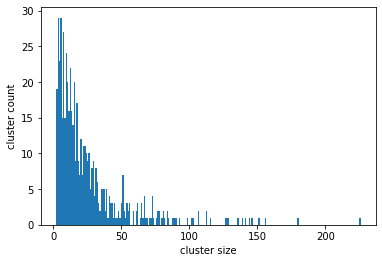

In [63]:
import matplotlib.pyplot as plt
plt.xlabel('cluster size')
plt.ylabel('cluster count')
plt.hist([len(cluster) for cluster in clusters], bins=226)
plt.show()
cluster_count = lambda min_size: len([cluster for cluster in clusters if len(cluster)>=min_size])
clusters = list(filter(lambda x: len(x)>1, clusters))

In [ ]:
rows = list()
for cluster in clusters:
  points = [list(crime_loc[loc]) for loc in cluster]
  mean = tuple(np.mean(points, axis=0))
  var = np.cov(points, rowvar=False)
  print(mean, var)
  rows.append([len(points), mean, var[0,0], var[1,1], var[0,1]])

In [60]:
import csv

with open(path+"hotspot_gaussian.csv", "w") as f:
    writer = csv.writer(f)
    writer.writerow(['cluster_size', 'mean', 'var_latitude', 'var_longitude', 'cov'])
    writer.writerows(rows)

In [67]:
import folium
sf_loc = (37.76, -122.44)
sf_map = folium.Map(location=sf_loc, zoom_start=11, tiles='Stamen Terrain')
colormap = ['red', 'blue', 'green', 'gold', 'black', 'yellowgreen', 'magenta', 'darkviolet', 'teal', 'chocolate',
            'deeppink', 'darkorange', 'darkslateblue', 'lightseagreen', 'salmon', 'violet', 'turquoise', 'deepskyblue',
            'lime', 'sandybrown']
for i, cluster in enumerate(clusters[130:150]):
  for loc in cluster:
    folium.CircleMarker(crime_loc[loc], radius=1, color=colormap[i]).add_to(sf_map)
sf_map

In [ ]:
min(incident_df['Latitude']), max(incident_df['Latitude']), min(incident_df['Longitude']), max(incident_df['Longitude'])

(37.70802018416812,
 37.82999075468864,
 -122.51129492624534,
 -122.36374276695295)

In [68]:
print(geodesic((37.70802018416812, -122.51129492624534), (37.82999075468864, -122.36374276695295)).km)

print(geodesic((37.82999075468864, 100.0), (37.82999075468864, 100.012)).km)
print(geodesic((37.70802018416812, 100.0), (37.70802018416812, 100.012)).km)

print(geodesic((37.82999075468864, 100.0), (37.83999075468864, 100.0)).km)
print(geodesic((37.70802018416812, 100.0), (37.71802018416812, 100.012)).km)

#latitude +- 0.01
#longitude +- 0.012

18.769172001819797
1.0564180977387347
1.058154687644922
1.109933564593621
1.533441316169932
